<a href="https://colab.research.google.com/github/pepetonof/IC-Tutorial/blob/main/Tutorial-IC-NN-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np

# Obtiene el Conjunto de Datos
Divide el conjunto de datos en datos de entrenamiento, validación y prueba.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

batch_size = 64
validation_split = 0.2  # 20% para validación
random_seed = 42

transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5,), (0.5,))
                                ])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = int((1 - validation_split) * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')

## Muestra del conjunto de datos

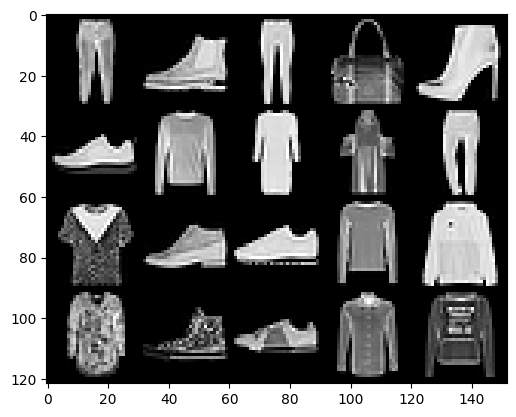

('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img, _ = next(iter(train_loader))
grid = torchvision.utils.make_grid(img[:20], nrow = 5, padding = 2)
imshow(grid)

print(classes)

# Clasificación utilizando una Red Neuronal Simple

In [4]:
input_shape = img.shape[2:]

class basicNN(nn.Module):
    def __init__(self):
        super(basicNN, self).__init__()
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, input_shape[0]*input_shape[1])  # Aplanar las imágenes
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x #F.log_softmax(x, dim=1)

nn.svg

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_nn  = basicNN().to(device)

#Optimizer and criteria
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Funciones de entrenamiento y prueba

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    _predicted = []
    _labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            _predicted.extend(predicted.cpu().numpy())
            _labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')
    return _predicted, _labels

In [7]:
#Entrenar el modelo simple
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_nn, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/20, Train Loss: 0.6845, Train Accuracy: 0.7687, Val Loss: 0.5056, Val Accuracy: 0.8223
Epoch 2/20, Train Loss: 0.4588, Train Accuracy: 0.8386, Val Loss: 0.4521, Val Accuracy: 0.8469
Epoch 3/20, Train Loss: 0.4196, Train Accuracy: 0.8529, Val Loss: 0.4247, Val Accuracy: 0.8517
Epoch 4/20, Train Loss: 0.3922, Train Accuracy: 0.8604, Val Loss: 0.3923, Val Accuracy: 0.8582
Epoch 5/20, Train Loss: 0.3752, Train Accuracy: 0.8652, Val Loss: 0.3915, Val Accuracy: 0.8587
Epoch 6/20, Train Loss: 0.3612, Train Accuracy: 0.8718, Val Loss: 0.3683, Val Accuracy: 0.8680
Epoch 7/20, Train Loss: 0.3486, Train Accuracy: 0.8741, Val Loss: 0.3681, Val Accuracy: 0.8708
Epoch 8/20, Train Loss: 0.3351, Train Accuracy: 0.8799, Val Loss: 0.3743, Val Accuracy: 0.8637
Epoch 9/20, Train Loss: 0.3231, Train Accuracy: 0.8831, Val Loss: 0.3652, Val Accuracy: 0.8708
Epoch 10/20, Train Loss: 0.3176, Train Accuracy: 0.8847, Val Loss: 0.3692, Val Accuracy: 0.8651
Epoch 11/20, Train Loss: 0.3095, Train Accuracy: 

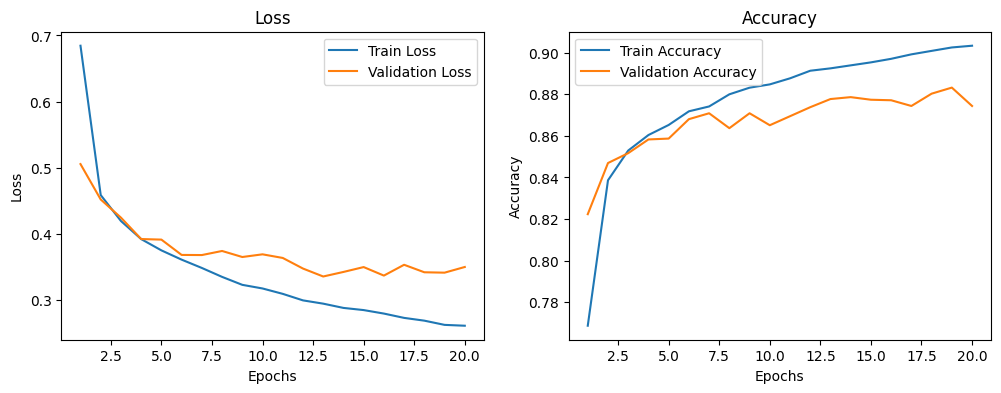

In [8]:
#Graficar resultados de entrenamiento
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Accuracy on the test set: 86.64%


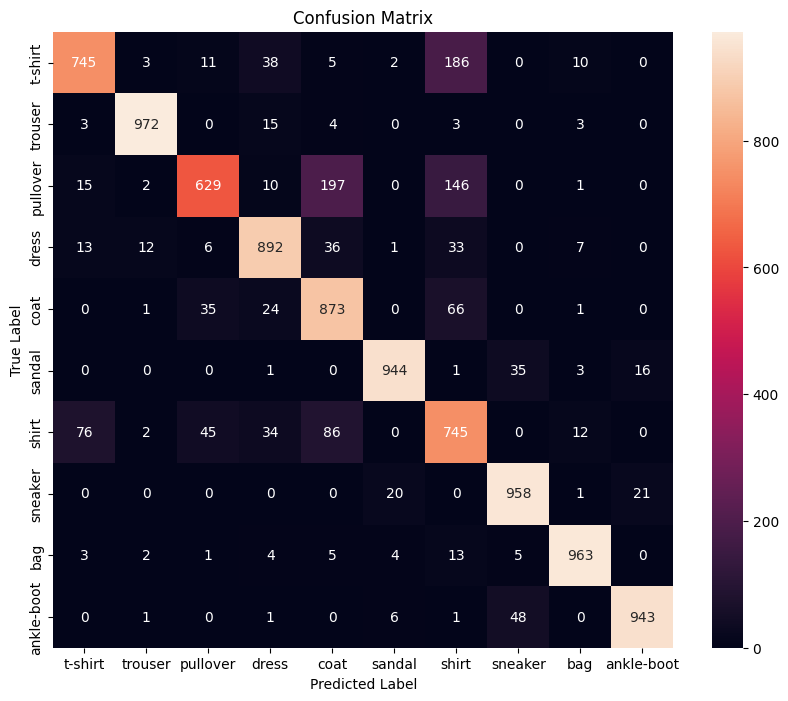

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test model
predicted, labels = test_model(model_nn, test_loader)

# Confusion matrix
cm = confusion_matrix(labels, predicted)
# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",# cmap=plt.cm.Heat,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot

In [10]:
from torchsummary import summary
#Evaluar no. parametros
no_parameters_modelnn = sum(p.numel() for p in model_nn.parameters() if p.requires_grad)
print(f'No. parameters = {no_parameters_modelnn}')

summary(model_nn, input_size=(1, input_shape[0], input_shape[1]))


No. parameters = 26506
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
            Linear-2                   [-1, 32]           1,056
            Linear-3                   [-1, 10]             330
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


# Convolucion discreta en imágenes
La figura muestra una convolución de un filtro o kernel de convolución de *3x3* sobre una imagen de *4x4*.

Notar que las dimensiones se reducen y no es posible aplicar la convolución en los píxeles de todos los bordes

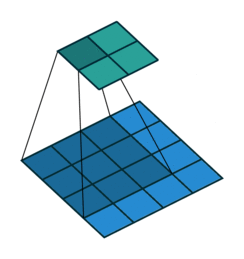

Para evitar la reducción de las dimensiones, usualmente se utiliza un padding que permite aplicar los filtros de 3x3 a cada uno de los filtros. Note que la salida mantiene las dimensiones.

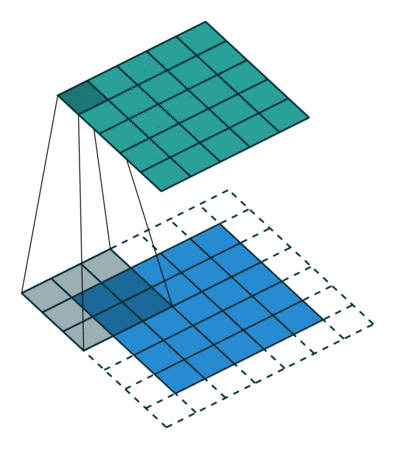

# Pooling

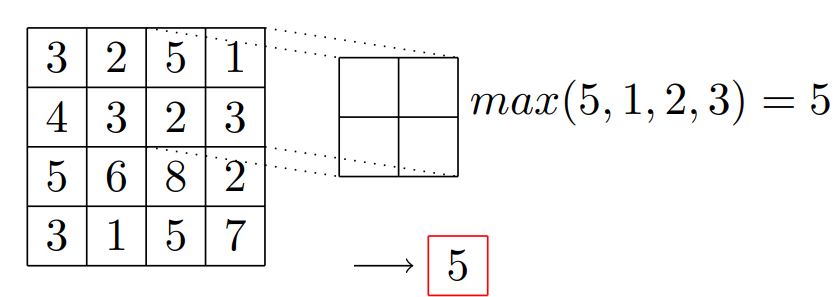

#Modelo CNN

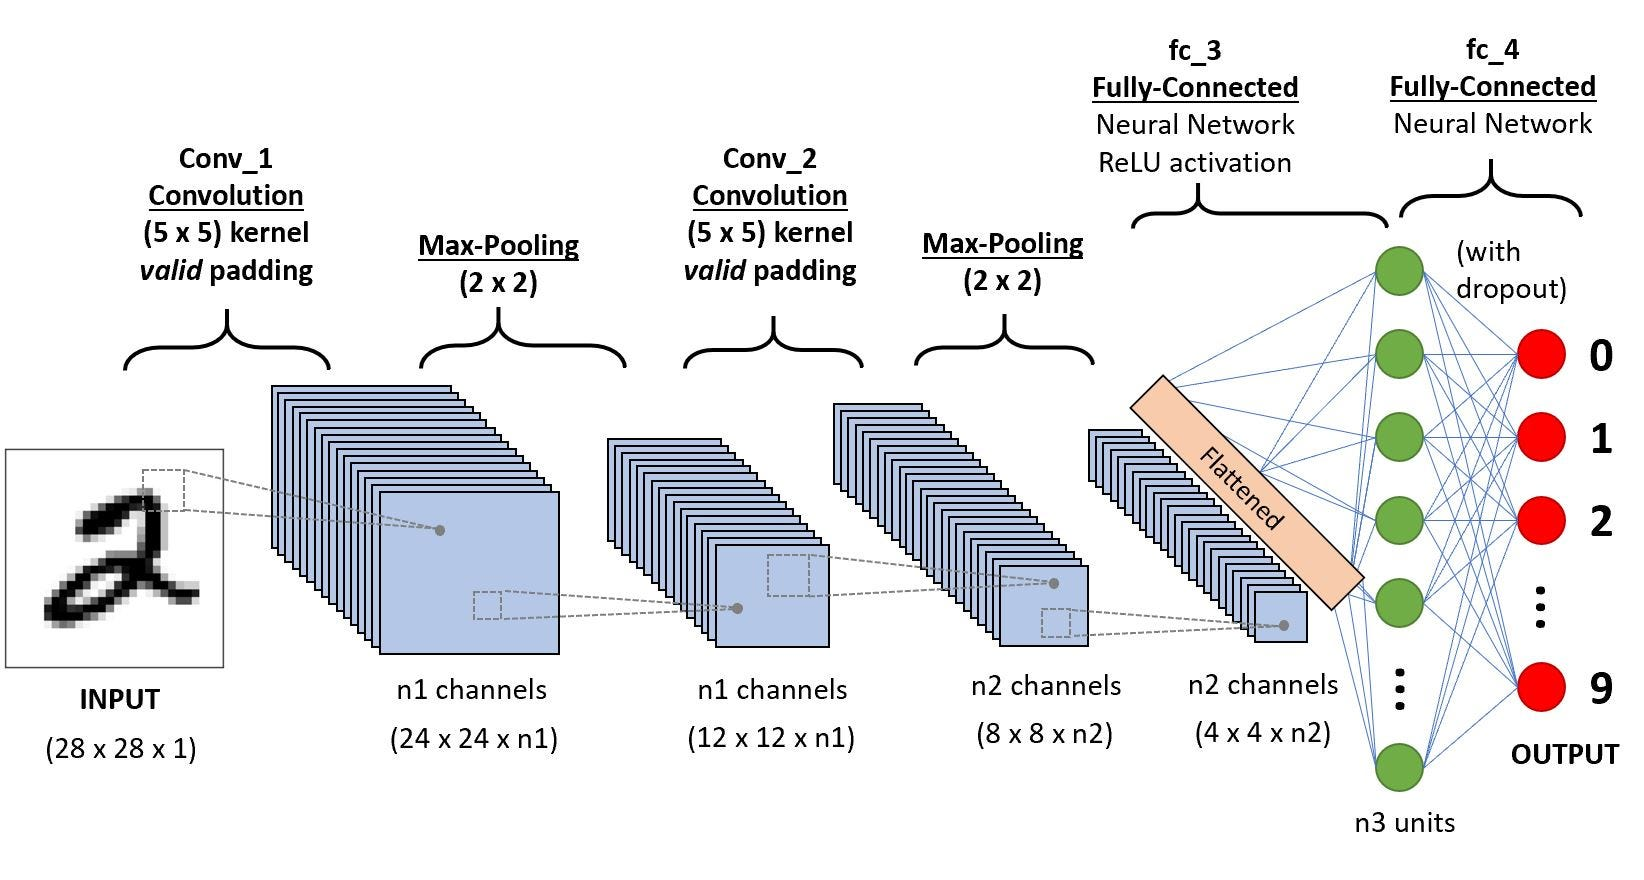

In [11]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()

        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)  # Output: [batch_size, 32, 26, 26]
        self.relu = nn.ReLU()
        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # Output: [batch_size, 64, 11, 11]

        self.fc1 = nn.Linear(32 * 5 * 5, 10)  # Flattening: [batch_size, 64*5*5]
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        # Shape: [batch_size, 32, 13, 13]
        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        # Shape: [batch_size, 64, 5, 5]

        #
        x = x.view(-1, 32 * 5 * 5) # Flattening
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        x = self.fc1(x)
        return x#F.log_softmax(x, dim=1)

cnn.svg

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn  = basicCNN().to(device)

#Optimizer and criteria
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
#Entrenar el modelo cnn
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_cnn, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/20, Train Loss: 0.6146, Train Accuracy: 0.7785, Val Loss: 0.4670, Val Accuracy: 0.8359
Epoch 2/20, Train Loss: 0.4084, Train Accuracy: 0.8547, Val Loss: 0.4005, Val Accuracy: 0.8545
Epoch 3/20, Train Loss: 0.3627, Train Accuracy: 0.8709, Val Loss: 0.3750, Val Accuracy: 0.8632
Epoch 4/20, Train Loss: 0.3413, Train Accuracy: 0.8772, Val Loss: 0.3560, Val Accuracy: 0.8742
Epoch 5/20, Train Loss: 0.3203, Train Accuracy: 0.8848, Val Loss: 0.3367, Val Accuracy: 0.8812
Epoch 6/20, Train Loss: 0.3058, Train Accuracy: 0.8891, Val Loss: 0.3392, Val Accuracy: 0.8782
Epoch 7/20, Train Loss: 0.2945, Train Accuracy: 0.8930, Val Loss: 0.3140, Val Accuracy: 0.8871
Epoch 8/20, Train Loss: 0.2840, Train Accuracy: 0.8972, Val Loss: 0.3145, Val Accuracy: 0.8873
Epoch 9/20, Train Loss: 0.2751, Train Accuracy: 0.9010, Val Loss: 0.3060, Val Accuracy: 0.8922
Epoch 10/20, Train Loss: 0.2657, Train Accuracy: 0.9048, Val Loss: 0.2995, Val Accuracy: 0.8943
Epoch 11/20, Train Loss: 0.2588, Train Accuracy: 

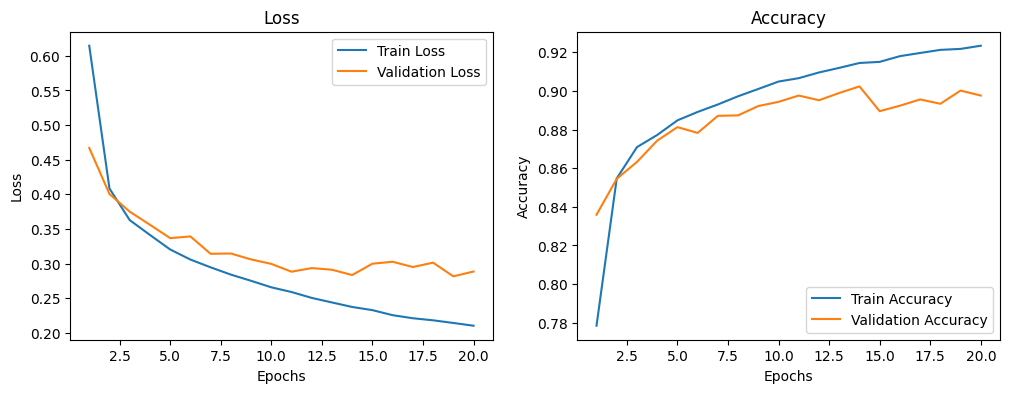

In [14]:
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Accuracy on the test set: 89.37%


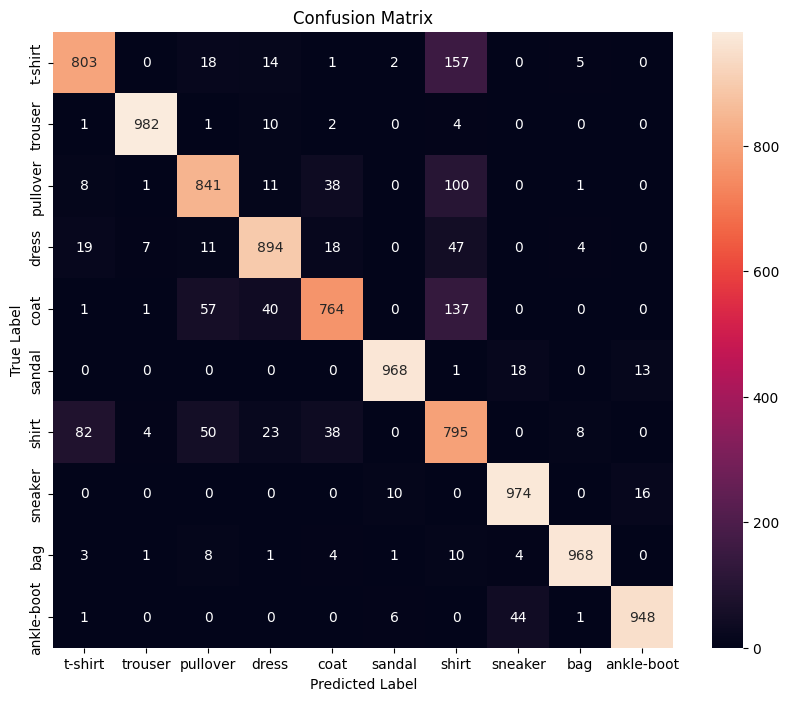

In [15]:
# Test model
predicted, labels = test_model(model_cnn, test_loader)

# Confusion matrix
cm = confusion_matrix(labels, predicted)
# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",# cmap=plt.cm.Heat,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot

In [16]:
from torchsummary import summary
#Evaluar no. parametros
no_parameters_modelnn = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f'No. parameters = {no_parameters_modelnn}')

summary(model_cnn, input_size=(1, input_shape[0], input_shape[1]))

No. parameters = 12810
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 32, 11, 11]           4,640
            Linear-3                   [-1, 10]           8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.05
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
